# 1. Install Dependencies and Setup

In [1]:
import tensorflow as tf
import os

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove low quality images

In [4]:
import cv2
import imghdr

C:\Users\Kenneth\AppData\Local\Temp\ipykernel_23100\4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [85]:
data_dir = 'tracks_data' 

In [86]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [87]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [88]:
import numpy as np
from matplotlib import pyplot as plt

In [89]:
data = tf.keras.utils.image_dataset_from_directory('tracks_data')

Found 47 files belonging to 2 classes.


In [90]:
data_iterator = data.as_numpy_iterator()

In [91]:
batch = data_iterator.next()

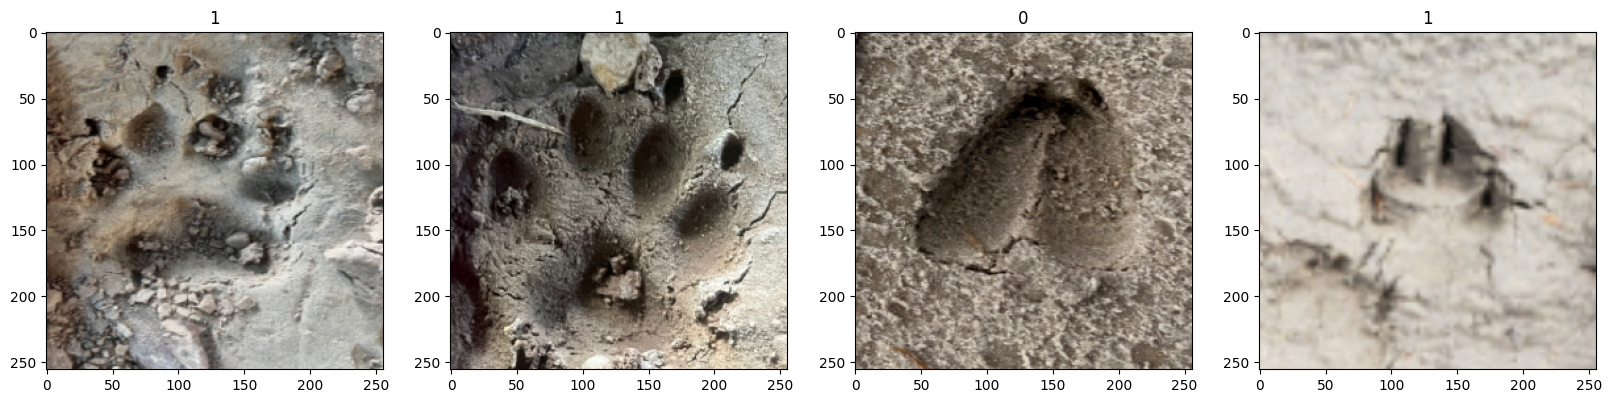

In [92]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [81]:
data = data.map(lambda x,y: (x/255, y))

In [93]:
data.as_numpy_iterator().next()

(array([[[[ 84.83008  ,  75.509766 ,  76.509766 ],
          [ 88.14307  ,  82.25415  ,  82.21655  ],
          [ 87.90283  ,  84.886475 ,  84.47388  ],
          ...,
          [ 88.15039  ,  87.90283  ,  90.16016  ],
          [ 91.34888  ,  91.34888  ,  91.04492  ],
          [ 95.83008  ,  95.83008  ,  94.16992  ]],
 
         [[ 86.03906  ,  81.56836  ,  82.56836  ],
          [ 93.403564 ,  90.48926  ,  91.48926  ],
          [ 92.021484 ,  90.78369  ,  91.40869  ],
          ...,
          [ 84.63721  ,  85.20337  ,  89.07349  ],
          [ 91.401855 ,  91.01953  ,  93.78662  ],
          [ 99.58789  ,  98.56836  , 100.09766  ]],
 
         [[110.93945  , 109.63867  , 109.78906  ],
          [106.480225 , 105.89844  , 107.11084  ],
          [ 94.91455  ,  94.82056  ,  96.295166 ],
          ...,
          [ 93.74609  ,  95.66431  ,  98.7583   ],
          [ 96.14844  ,  97.52246  , 101.89087  ],
          [ 98.90234  ,  96.90234  , 103.30078  ]],
 
         ...,
 
         [[1

# 5. Split Data

In [94]:
batch[0].shape

(32, 256, 256, 3)

In [95]:
len(data)

2

In [96]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [97]:
train_size

1

In [98]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [99]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [100]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [101]:
model = Sequential()

In [102]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [103]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [104]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 16)       

# 7. Train

In [105]:
logdir='logs'

In [106]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [107]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


1/1 [==============================] - ETA: 0s - loss: 19.1817 - accuracy: 0.5938

ValueError: Expected input data to be non-empty.

# 8. Plot Performance

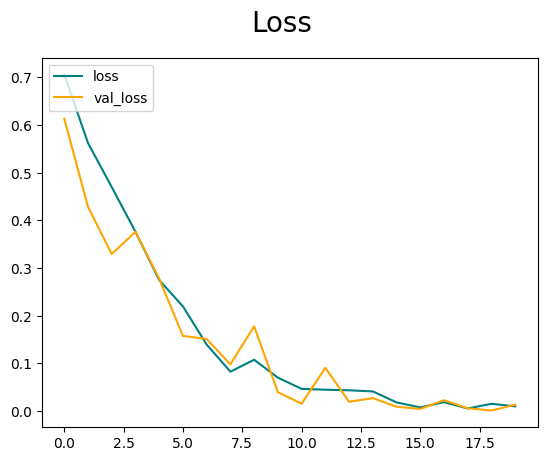

In [29]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

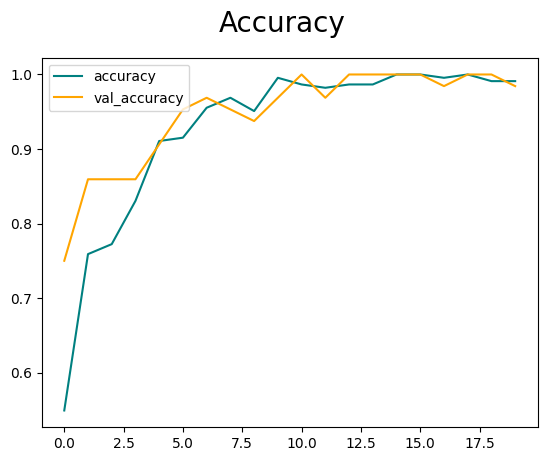

In [30]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [31]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [32]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [33]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 216ms/step


In [34]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [35]:
import cv2

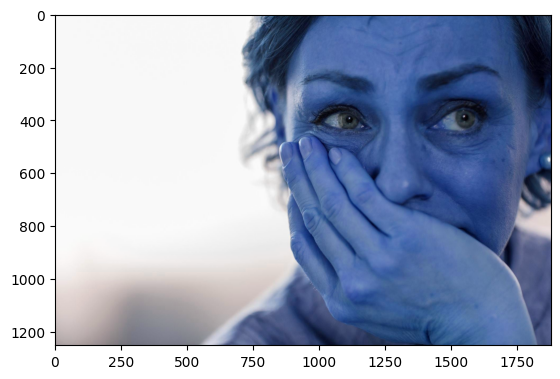

In [54]:
img = cv2.imread('data/sad/0x0.jpg')
plt.imshow(img)
plt.show()

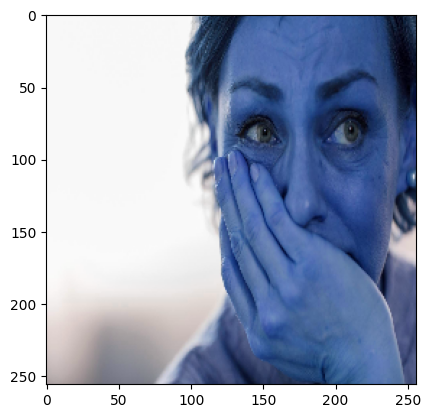

In [55]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [56]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 37ms/step


In [57]:
yhat

array([[0.9938907]], dtype=float32)

In [58]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


# 11. Save the Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('models','imageclassifier.h5'))

In [ ]:
new_model = load_model('imageclassifier.h5')

In [ ]:
new_model.predict(np.expand_dims(resize/255, 0))

array([[0.01972741]], dtype=float32)